In [0]:
!pip install wget
!pip install hyperdash
!pip install tokenizers
!pip install transformers
!hd login --github


Opening browser, please wait. If something goes wrong, press CTRL+C to cancel.
 SSH'd into a remote machine, or just don't have access to a browser? Open this link in any browser and then copy/paste the provided access token: https://hyperdash.io/oauth/github/start?state=client_cli_manual 
Waiting for Github OAuth to complete.
If something goes wrong, press CTRL+C to cancel.
Access token: DcGFHT5cFa4eikxp97lHR789au1i92kM8KgSLmbYq/E=
Successfully logged in! We also installed: 6dqfQAL9Xij4kBZzoFO+iDTxNHszbaxsxhzaeg0f/DE= as your default API key


In [0]:
DEVICE= "GPU"
testNMT=True
SAMPLE=False
MAX_LEN=100
INPUT_VOCAB=10000
OUTPUT_VOCAB=10000
BATCH_SIZE=128
USE_PRETRAINED=False
TOKENIZER="spacy"

if TOKENIZER=="BERT":
    trainNMT=False
    USE_PRETRAINED=False
if testNMT:
    USE_PRETRAINED=False

# Data Preparation

In [0]:
import torch
if DEVICE=="CPU":
    device=torch.device('cpu')
elif DEVICE=="TPU": 
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl
    device = xm.xla_device() 
else:
    device=torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))

In [0]:
print(device)
from google.colab import drive
drive.mount('/content/drive')

cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#@title Load Glove
def load_glove_embedding(vocab,glove):

    nlp = glove
    vocab_size = len(vocab.word2idx)
    word_vec_size = 300
    embedding = np.zeros((vocab_size, word_vec_size))
    unk_count = 0
    
    print('='*100)
    print('Loading spacy glove embedding:')
    print('- Vocabulary size: {}'.format(vocab_size))
    print('- Word vector size: {}'.format(word_vec_size))
    
    for token, index in tqdm(vocab.word2idx.items()):
        if token == vocab.special["pad_token"]: 
            continue
        elif token in [vocab.special["eos_token"], vocab.special["init_token"], vocab.special["unk_token"]]: 
            vector = np.random.rand(word_vec_size,)
        elif token in nlp.keys():
            vector = nlp[token]
        else:
            vector = embedding[vocab.word2idx[vocab.special["unk_token"]]]
            unk_count += 1
            
        embedding[index] = vector
        
    print('\n- Unknown word count: {}'.format(unk_count))
    print('='*100 + '\n')
        
    return torch.from_numpy(embedding).float()

In [0]:
#@title Download Glove
import os
import wget
import zipfile
def download_glove(link="http://nlp.stanford.edu/data/glove.6B.zip"):
    print("Downloading glove")
    if not os.path.exists("./glove"):
        if not os.path.exists("glove.zip"):
            wget.download(link,"glove.zip")
        print("Extracting Glove")
        with zipfile.ZipFile("./glove.zip", 'r') as zip_ref:
            zip_ref.extractall("glove")


import numpy as np
from tqdm import tqdm
def loadGloveModel(gloveFile="./glove/glove.6B.300d.txt"):
    if not os.path.exists(gloveFile):
        download_glove()
    print("Loading Glove Model")
    with open(gloveFile,'r') as f:
        model = {}
        for line in tqdm(f,position=0,leave=False):
            splitLine = line.split()
            try:
                word = " ".join(splitLine[0:-300])
                embedding = np.array([float(val) for val in splitLine[-300:]])
                model[word] = embedding
            except:
                print(f"Error in {splitLine[0]}")
                print(f"Vect : \n{splitLine[1:]}")
        print("Done.",len(model)," words loaded!")
    return model

In [0]:
#@title QGenDataset
import wget
import json
from tqdm import tqdm
import os
import torchtext
import spacy
import zipfile
import unicodedata
import re
class QGenDataset(object):
    def __init__(self,squad=True,USE_ENTIRE_SENTENCE=True,test_nmt=False):
        self.USE_ENTIRE_SENTENCE=USE_ENTIRE_SENTENCE
        if squad and not test_nmt:
            if not os.path.exists("./train-v2.0.json"):
                wget.download("https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json")
            with open("./train-v2.0.json",'r') as f:
                self.raw_data=json.load(f)
            self.data=self._get_dataset()
        if test_nmt:
            with zipfile.ZipFile("/content/drive/My Drive/Thesis/spa-eng.zip", 'r') as zip_ref:
                zip_ref.extractall("./spa/")
            with open("./spa/spa.txt",'r') as f:
                self.nmt_raw=f.read().strip().split('\n')
            self.__get_NMT__()
    def __get_NMT__(self):
        original_word_pairs = [[w for w in l.split('\t')] for l in self.nmt_raw]
        self.eng=[i[0] for i in original_word_pairs]
        self.spa=[i[1] for i in original_word_pairs]

    def get_AQ(self,max_len=80,sample=True):
        raw_data = {'ans' : [line[0] for line in self.data], 'que': [line[1] for line in self.data]}
        df = pd.DataFrame(raw_data, columns=["ans", "que"])
        # remove very long sentences and sentences where translations are 
        # not of roughly equal length
        df['ans_len'] = df['ans'].str.count(' ')
        df['que_len'] = df['que'].str.count(' ')
        df = df.query('ans_len <'+str(max_len)+' & que_len <'+str(max_len))
        df = df.drop_duplicates()
        if sample:
            return df["ans"].values[:2000],df["que"].values[:2000]
        return df["ans"].values,df["que"].values
        

    def get_NMT(self,sample=False):
        if sample:
            return self.eng[:2000],self.spa[:2000]   
        return self.eng,self.spa 

    def _create_dataset(self,data,normalize=True):
        load_failure=0
        try:
            if "data" in data.keys():
                data=data["data"]
        except:
            pass
        que_ans=[]
        for topic in data:
            for para in topic["paragraphs"]:
                for qa in para["qas"]:
                    try:
                        res=[]
                        if normalize:
                            res.append(self._normalize(self._get_sentence(para["context"],qa["answers"][0]["answer_start"],qa["answers"][0]["text"])))
                            res.append(self._normalize(qa["question"]))
                        else:
                            res.append(self._get_sentence(para["context"],qa["answers"][0]["answer_start"],qa["answers"][0]["text"]))
                            res.append(qa["question"])
                        que_ans.append(res)
                    except:
                        load_failure+=1
        print("Load Failure : ",load_failure)
        return que_ans
    @staticmethod
    def _get_sentence(context,position,text):
        if "." in text[:-1]:
            return_2=True
        else:
            return_2=False
        context=context.split(".")
        count=0
        for sent in range(len(context)):
            if count+len(context[sent])>position:
                if return_2:
                    return ".".join(context[sent:sent+2])
                else:
                    return context[sent]
            else:
                count+=len(context[sent])+1
        return False

    def _get_dataset(self,normalize=True):
        data =  self._create_dataset(self.raw_data,normalize=normalize)
        return data  
            
    
    def __len__(self):
        return self.data_len
    def apply(self,function,all=True):
        for i in tqdm(range(self.data_len),position=0,leave=True):
            self.context[i]=function(self.context[i])
            self.answers[i]=function(self.answers[i])
            self.questions[i]=function(self.questions[i])

    def bert_format(self):
        X=[0 for i in range(self.data_len)]
        Y=[0 for i in range(self.data_len)]
        for i in range(self.data_len):
            X[i]="[CLS] " + self.context[i] +"[SEP]"+ self.answers[i] + "[SEP]"
            Y[i]=self.questions[i]
        return (X,Y)
    @staticmethod
    def unicodeToAscii(s):
        return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
    def _normalize(self,s):
        s = self.unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        return s





In [0]:
#@title Language Index
import spacy
from collections import Counter 
import sys
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

class LanguageIndex():

    def __init__(self, lang,tokenizer="spacy", pad="<PAD>",init_token="<SOS>",eos_token="<EOS>",unk_token="<UNK>",max_len=None,vocab_size=None,lower_case=True):
        """ lang are the list of phrases from each language"""
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.special={}
        self.max_len=max_len
        self.vocab_size=vocab_size-4 if vocab_size!=None else sys.maxsize
        self.lower=lower_case
        self.tokenizer=tokenizer
        if self.tokenizer=="BERT":
            model_type = 'bert-base-uncased'
            self.bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

        # add a padding token with index 0
        self.word2idx[pad] = 0
        self.special["pad_token"]=pad

        self.word2idx[init_token] = 1
        self.special["init_token"]=init_token

        self.word2idx[eos_token] = 2
        self.special["eos_token"]=eos_token

        self.word2idx[unk_token] = 3
        self.special["unk_token"]=unk_token

        self.vocab = set()
        self.counter=Counter()
        self.spacy=None
        self.create_index()
        

    @staticmethod
    def unicode_to_ascii(s):
        """
        Normalizes latin chars with accent to their canonical decomposition
        """
        return ''.join(c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')
        
    @staticmethod
    def preprocess_sentence(w):
        w = unicode_to_ascii(w.lower().strip())
        
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ." 
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        
        w = w.rstrip().strip()
        
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        return w
        
    def tokenize(self,phrase):
        if self.tokenizer=="spacy":
            if not self.spacy:
                self.spacy = spacy.load('en')
            return [tok.text for tok in self.spacy.tokenizer(phrase)]
        if self.tokenizer=="BERT":
            return self.bert_tokenizer.tokenize(phrase)
        else:
            return self.preprocess(phrase)

    def create_index(self):
        for phrase in self.lang:
            # update with individual tokens
            tokens=self.tokenize(phrase.lower() if self.lower else phrase)
            self.vocab.update(tokens)
            self.counter.update(tokens)
            
        # sort the vocab
        self.vocab = sorted(self.vocab)
        start_index = max(self.word2idx.values())+1
        
        # word to index mapping
        for index, word in enumerate(self.counter.most_common(self.vocab_size)):
            self.word2idx[word[0]] = index + start_index 
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

    def encode_batch(self,batch,special_tokens=True):
        return np.array([self.encode(obj,special_tokens=special_tokens) for obj in batch],dtype=np.int64)
    def decode_batch(self,batch):
        return [self.decode(obj) for obj in batch]

    def encode(self,input,special_tokens=True):
        pad_len=self.max_len
        input=input.lower() if self.lower else input
        tokens=[tok for tok in self.tokenize(input)]
        if pad_len!=None:
            if len(tokens)>pad_len-(2 if special_tokens else 0):
                if special_tokens:
                    return [1]+[self.word2idx[s] if s in self.word2idx.keys() else 3 for s in tokens][:pad_len-2]+[2]
                else:
                    return [self.word2idx[s] if s in self.word2idx.keys() else 3 for s in tokens][:pad_len]
            else:
                return ([1] if special_tokens else []) + [self.word2idx[s] if s in self.word2idx.keys() else 3 for s in tokens] +([2] if special_tokens else []) +[0 for i in range(pad_len-(2 if special_tokens else 0)-len(tokens))]
        return ([1] if special_tokens else []) + [self.word2idx[s] if s in self.word2idx.keys() else 3 for s in tokens] +([2] if special_tokens else []) 
    def decode(self,input,to_string=False):
        sent=[self.idx2word[s] if s in self.idx2word.keys() else self.special["unk_token"] for s in input]
        if self.tokenizer=="BERT" and to_string:
            return self.bert_tokenizer.convert_tokens_to_string(sent)
        return sent
    def vocab_size_final(self):
        return len(self.word2idx.keys())

In [0]:
qg=QGenDataset(test_nmt=testNMT)
if testNMT:
    input_,output_=qg.get_NMT(sample=SAMPLE)
else:
    input_,output_=qg.get_AQ(sample=SAMPLE,max_len=MAX_LEN)

In [0]:
#@title Train Test Split
from sklearn.model_selection import train_test_split
train_set_input,test_set_input,train_set_output,test_set_output=train_test_split(input_,output_,test_size=0.1)
input_train,input_test,output_train,output_test=train_test_split(train_set_input,train_set_output,test_size=0.1)

In [0]:

inpLang=LanguageIndex(input_train,vocab_size=INPUT_VOCAB,max_len=MAX_LEN,tokenizer=TOKENIZER)
optLang=LanguageIndex(output_train,vocab_size=OUTPUT_VOCAB,max_len=MAX_LEN,tokenizer=TOKENIZER)


In [0]:
#@title Load Glove Embeddings
if USE_PRETRAINED:
    import pickle 
    with open("/content/drive/My Drive/glove.p",'rb') as f:
        glove=pickle.load(f)

if USE_PRETRAINED:
    glove_opt=load_glove_embedding(optLang,glove)
    glove_inp=load_glove_embedding(inpLang,glove)
    OUTPUT_VOCAB=glove_opt.shape[0]
    INPUT_VOCAB=glove_inp.shape[0]
else:
    glove_inp=None
    glove_opt=None

In [0]:
input_train_tokens=inpLang.encode_batch(input_train)
input_test_tokens=inpLang.encode_batch(input_test)
ouptut_train_tokens=optLang.encode_batch(output_train)
output_test_tokens=optLang.encode_batch(output_test)

In [0]:
#@title Add data to torch dataset
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        # TODO: convert this into torch code is possible
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x,y,x_len

    def __len__(self):
        return len(self.data)

In [0]:
#@title Add data to torch test dataset
class TestData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x,y

    def __len__(self):
        return len(self.data)
TEST_BATCH_SIZE=20
final_test_dataset=TestData(test_set_input,test_set_output)
final_dataloader=DataLoader(final_test_dataset,batch_size=TEST_BATCH_SIZE)

In [0]:
#@title Create Dataloader
train_dataset = MyData(input_train_tokens,ouptut_train_tokens)
test_dataset = MyData(input_test_tokens, output_test_tokens)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [0]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random
import torch
from torch import optim
import torch.nn.functional as F


In [0]:
def log_param(path,**kwargs):
    with open(path,'w') as f:
        for key, value in kwargs.items(): 
            f.write(f"{key} == {value}\n")
    print(f"Saved Hyperparameters at {path}")

In [0]:
#@title Get Params for model
def get_params():
    params={}
    params_to_save=["BATCH_SIZE","DEVICE","testNMT","SAMPLE","MAX_LEN",
                    "INPUT_VOCAB","OUTPUT_VOCAB","BATCH_SIZE","USE_PRETRAINED",
                    "INPUT_DIM","OUTPUT_DIM","ENC_EMB_DIM","DEC_HID_DIM","HID_DIM",
                    "ENC_DROPOUT","DEC_DROPOUT","N_LAYERS","LR","EPOCHS","HYPERDASH","CLIP","EPOCHS","TOKENIZER"]
    for name in params_to_save:
        try:
            params[name]=globals().get(name,None)
        except:
            pass
    return params
def log_hyperdash(exp,**kwargs):
    for k,v in kwargs.items():
        exp.param(k,v)


#Basic Seq2seq with 2 layers

In [0]:
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3


In [0]:
class Encoder(nn.Module):
    def __init__(self,input_dim,emb_dim,hid_dim,n_layers,dropout,embedding=None):
        super(Encoder,self).__init__()
        self.hid_dim=hid_dim
        self.n_layers=n_layers
        self.embedding=nn.Embedding(input_dim,emb_dim)
        if embedding!=None:
            self.embedding.load_state_dict({'weight': embedding})
            self.embedding.weight.requires_grad = False
        self.rnn=nn.LSTM(emb_dim,hid_dim,n_layers,dropout=dropout)
        self.dropout=nn.Dropout(dropout)
    def forward(self,src):
        src=src.transpose(0,1)
        embedded=self.dropout(self.embedding(src))
        output,(hidden,cell)=self.rnn(embedded)
        return hidden,cell

In [0]:
class Decoder(nn.Module):
    def __init__(self,output_dim,emb_dim,hid_dim,n_layers,dropout,embedding=None):
        super(Decoder,self).__init__()
        self.output_dim=output_dim
        self.hid_dim=hid_dim
        self.n_layers=n_layers
        self.embedding=nn.Embedding(output_dim,emb_dim)
        if embedding!=None:
            self.embedding.load_state_dict({'weight': embedding})
            self.embedding.weight.requires_grad = False
        self.rnn=nn.LSTM(emb_dim,hid_dim,n_layers,dropout=dropout)
        self.fc=nn.Linear(hid_dim,output_dim)
        # self.softmax=nn.Softmax(dim=1)
        self.dropout=nn.Dropout(dropout)
    def forward(self,input,hidden,cell):
        input=input.unsqueeze(0)
        embedded=self.dropout(self.embedding(input))
        output,(hidden,cell)=self.rnn(embedded,(hidden,cell))
        prediction=self.fc(output.squeeze(0))
        # prediction=self.softmax(prediction)
        return prediction,hidden,cell


In [0]:
class Seq2seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super(Seq2seq,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.device=device
    def forward(self,src,trg,teacher_forcing_ratio=0.5):
        batch_size=trg.shape[0]
        trg_len=trg.shape[1]
        trg_vocab_size=self.decoder.output_dim
        outputs=torch.zeros(trg_len,batch_size,trg_vocab_size).to(self.device)
        hidden,cell=self.encoder(src)
        input=trg[:,0]
        for t in range(1,trg_len):
            output,hidden,cell=self.decoder(input,hidden,cell)
            outputs[t]=output
            teacher_force=random.random()<teacher_forcing_ratio
            top1=output.argmax(1)
            input = trg[:,t] if teacher_force else top1
        return outputs
    def decode(self,input,inpLang,optLang,max_len=10):
        stop_token=optLang.word2idx[optLang.special["eos_token"]]
        start_token=optLang.word2idx[optLang.special["init_token"]]
        src=torch.tensor(inpLang.encode(input),device=self.device).unsqueeze(1).transpose(0,1)
        batch_size=src.shape[1]
        trg_vocab_size=self.decoder.output_dim
        hidden,cell=self.encoder(src)
        input=torch.tensor(start_token,device=self.device).unsqueeze(0)
        stop=False
        outputs=[]
        while not stop:
            output,hidden,cell=self.decoder(input,hidden,cell)
            top1=output.argmax(1)
            topk=torch.topk(output,5)
            input=top1
            if top1.item()==stop_token or len(outputs)>max_len:
                stop=True
            outputs.append(top1.item())
        return " ".join(optLang.decode(outputs))
    def batch_decode(self,input,inpLang,optLang,max_len=10):
        stop_token=optLang.word2idx[optLang.special["eos_token"]]
        start_token=optLang.word2idx[optLang.special["init_token"]]
        src=torch.tensor(inpLang.encode_batch(input),device=self.device)
        batch_size=src.shape[0]
        trg_vocab_size=self.decoder.output_dim
        hidden,cell=self.encoder(src)
        input=torch.tensor([start_token]*batch_size,device=self.device)
        stop=False
        outputs=[]
        while not stop:
            output,hidden,cell=self.decoder(input,hidden,cell)
            top1=output.argmax(1)
            topk=torch.topk(output,5)
            input=top1
            if len(outputs)>max_len:
                stop=True
            outputs.append(top1.cpu().tolist())
        outputs=(np.array(outputs).transpose().tolist())
        return [" ".join(i) for i in optLang.decode_batch(outputs)]



In [0]:
enc=Encoder(INPUT_VOCAB,ENC_EMB_DIM,HID_DIM,N_LAYERS,ENC_DROPOUT,embedding=glove_inp)
dec=Decoder(OUTPUT_VOCAB,DEC_EMB_DIM,HID_DIM,N_LAYERS,DEC_DROPOUT,embedding=glove_opt)

In [0]:
model = Seq2seq(enc, dec, device).to(device)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 300)
    (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 300)
    (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
    (fc): Linear(in_features=512, out_features=10000, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 18,666,640 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = optLang.word2idx[optLang.special["pad_token"]])

In [0]:
#@title Train loop
from tqdm import tqdm
def train(model,iterator,optimizer,criterion,clip,exp):
    model.train()
    epoch_loss=0
    print("Bathces: ",len(iterator))
    for i,(x,y,_) in tqdm(enumerate(iterator)):
        src=x.to(device)
        trg=y.to(device)
        optimizer.zero_grad()
        output=model(src,trg)
        trg=trg.transpose(0,1)
        output_dim=output.shape[-1]
        output=output[1:].view(-1,output_dim)
        trg=trg[1:].contiguous().view(-1)
        loss=criterion(output,trg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),clip)
        optimizer.step()
        epoch_loss+=loss.item()
        if exp!=None:
            exp.metric("batch",i)
            exp.metric("loss",loss.item())
    return epoch_loss/len(iterator)

In [0]:
#@title Eval loop
def eval(model,iterator,criterion,exp):
    model.eval()
    epoch_loss=0
    print("Bathces: ",len(iterator))
    with torch.no_grad():
        for i,(x,y,_) in enumerate(iterator):
            src=x.to(device)
            trg=y.to(device)
            optimizer.zero_grad()
            output=model(src,trg)
            trg=trg.transpose(0,1)
            output_dim=output.shape[-1]
            output=output[1:].view(-1,output_dim)
            trg=trg[1:].contiguous().view(-1)
            loss=criterion(output,trg)
            epoch_loss+=loss.item()
            if exp!=None:
                exp.metric("batch",i)
                exp.metric("loss",loss.item())
        inp=random.choice(input_)
        print("Input",inp)
        print("Output",model.decode(inp,inpLang,optLang))
    return epoch_loss/len(iterator)

In [0]:
#@title Test loop
def create_test_df(model,iterator,inpLang,optLang,save_path="./opt.csv"):
    model.eval()
    all_data=[]
    with torch.no_grad():
        for i,(x,y) in enumerate(iterator):
            pred=model.batch_decode(x,inpLang,optLang)
            data=list(zip(x,y,pred))
            all_data+=data
    df=pd.DataFrame(all_data,columns=["input","traget","pred"])
    df.to_csv(save_path)
    return df

In [0]:
#@title timer
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
model_path="/content/drive/My Drive/ALDA Project/seq2seq_vanilla/"
if not os.path.exists(model_path):
    os.mkdir(model_path)
import math
import pandas
import pickle

HYPERDASH=False
if HYPERDASH==True:
    from hyperdash import Experiment
    exp = Experiment("Question Generation -seq2seq vanilla")
else:
    exp=None
EPOCHS=5
CLIP=1
best_valid_loss=float('inf')
for epoch in range(EPOCHS):
    if HYPERDASH:
        exp.metric("epoch",epoch)
    st_time=time.time()
    train_loss=train(model,train_dataloader,optimizer,criterion,CLIP,exp)
    valid_loss=eval(model,test_dataloader,criterion,exp)
    e_time=time.time()
    epoch_mins, epoch_secs = epoch_time(st_time, e_time)
    if valid_loss<best_valid_loss:
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path+"model.pt")
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

with open(model_path+"inpLang.p",'wb') as f:
    pickle.dump(inpLang,f)
with open(model_path+"optLang.p",'wb') as f:
    pickle.dump(optLang,f)


0it [00:00, ?it/s]

Bathces:  12


12it [00:08,  1.36it/s]


Bathces:  1
Input Look at us.
Output tom . . <EOS>


0it [00:00, ?it/s]

Epoch: 01 | Time: 0m 9s
	Train Loss: 6.294 | Train PPL: 541.366
	 Val. Loss: 4.516 |  Val. PPL:  91.482
Bathces:  12


12it [00:08,  1.41it/s]


Bathces:  1


0it [00:00, ?it/s]

Input Get away!
Output ¡ . . <EOS>
Epoch: 02 | Time: 0m 8s
	Train Loss: 4.203 | Train PPL:  66.881
	 Val. Loss: 4.471 |  Val. PPL:  87.476
Bathces:  12


12it [00:08,  1.41it/s]


Bathces:  1


0it [00:00, ?it/s]

Input I work.
Output ¡ . . <EOS>
Epoch: 03 | Time: 0m 8s
	Train Loss: 3.989 | Train PPL:  54.021
	 Val. Loss: 4.510 |  Val. PPL:  90.889
Bathces:  12


2it [00:01,  1.21it/s]


KeyboardInterrupt: ignored

In [0]:
model.decode("i grew up in india",inpLang,optLang)

'¡ . . <EOS>'

In [0]:
import pandas as pd
create_test_df(model,final_dataloader,inpLang,optLang,save_path=model_path+"output.csv")
if HYPERDASH:
    exp.end()

#Seq2seq Context Transfer

In [0]:
INPUT_DIM = INPUT_VOCAB
OUTPUT_DIM = OUTPUT_VOCAB
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


In [0]:
class Encoder(nn.Module):
    def __init__(self,input_dim,emb_dim,hid_dim,dropout):
        super(Encoder,self).__init__()
        self.hid_dim=hid_dim
        self.input_dim=input_dim
        self.embedding=nn.Embedding(input_dim,emb_dim)
        self.rnn=nn.GRU(emb_dim,hid_dim)
        self.dropout=nn.Dropout(dropout)
    def forward(self,src):
        src=src.transpose(0,1)
        embedded = self.dropout(self.embedding(src))
        output,hidden=self.rnn(embedded)
        return hidden

In [0]:
class Decoder(nn.Module):
    def __init__(self,output_dim,emb_dim,hid_dim,dropout):
        super(Decoder,self).__init__()
        self.hid_dim=hid_dim
        self.output_dim=output_dim
        self.embedding=nn.Embedding(output_dim,emb_dim)
        self.rnn=nn.GRU(emb_dim+hid_dim,hid_dim)
        self.fc=nn.Linear(emb_dim+hid_dim*2,output_dim)
        self.softmax=nn.Softmax(dim=1)
        self.dropout=nn.Dropout(dropout)
    def forward(self,input,hidden,context):
        input = input.unsqueeze(0)
        embedded=self.embedding(input)
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1)
        prediction = self.fc(output)
        predcition=self.softmax(prediction)
        return prediction, hidden

In [0]:
class Seq2seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super(Seq2seq,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.device=device
    def forward(self,src,trg,teacher_forcing_ratio=0.5):
        trg=trg.transpose(0,1)
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
        return outputs
    def decode(self,input,inpLang,optLang):
        stop_token=optLang.word2idx[optLang.special["eos_token"]]
        start_token=optLang.word2idx[optLang.special["init_token"]]
        src=torch.tensor(inpLang.encode(input),device=self.device).unsqueeze(1).transpose(0,1)
        batch_size=src.shape[1]
        trg_vocab_size=self.decoder.output_dim
        hidden=self.encoder(src)
        context=hidden
        input=torch.tensor(start_token,device=self.device).unsqueeze(0)
        stop=False
        outputs=[]
        while not stop:
            output,hidden=self.decoder(input,hidden,context)
            top1=output.argmax(1)
            topk=torch.topk(output,5)
            input=top1
            if top1.item()==stop_token or len(outputs)>10:
                stop=True
            outputs.append(top1.item())
        return " ".join(optLang.decode(outputs))
    def batch_decode(self,input,inpLang,optLang,max_len=10):
        stop_token=optLang.word2idx[optLang.special["eos_token"]]
        start_token=optLang.word2idx[optLang.special["init_token"]]
        src=torch.tensor(inpLang.encode_batch(input),device=self.device)
        batch_size=src.shape[0]
        trg_vocab_size=self.decoder.output_dim
        hidden=self.encoder(src)
        context=hidden
        input=torch.tensor([start_token]*batch_size,device=self.device)
        stop=False
        outputs=[]
        while not stop:
            output,hidden=self.decoder(input,hidden,context)
            top1=output.argmax(1)
            topk=torch.topk(output,5)
            input=top1
            if len(outputs)>max_len:
                stop=True
            outputs.append(top1.cpu().tolist())
        outputs=(np.array(outputs).transpose().tolist())
        return [" ".join(i) for i in optLang.decode_batch(outputs)]


In [0]:

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2seq(enc, dec, device).to(device)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(45000, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(30000, 256)
    (rnn): GRU(768, 512)
    (fc): Linear(in_features=1280, out_features=30000, bias=True)
    (softmax): Softmax(dim=1)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 60,781,872 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters(),lr=0.0005)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = optLang.word2idx[optLang.special["pad_token"]])

In [0]:
#@title Train loop
def train(model,iterator,optimizer,criterion,clip,exp):
    model.train()
    epoch_loss=0
    print("Total Batches - ",len(iterator))
    for i,(x,y,_) in enumerate(iterator):
        src=x.to(device)
        trg=y.to(device)
        optimizer.zero_grad()
        output=model(src,trg)
        trg=trg.transpose(0,1)
        output_dim=output.shape[-1]
        output=output[1:].view(-1,output_dim)
        trg=trg[1:].contiguous().view(-1)
        loss=criterion(output,trg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),clip)
        optimizer.step()
        epoch_loss+=loss.item()
        exp.metric("batch",i)
        exp.metric("loss",loss.item())
    return epoch_loss/len(iterator)

In [0]:
#@title Eval loop

def eval(model,iterator,criterion,exp):
    model.eval()
    epoch_loss=0
    print("Total Batches - ",len(iterator))
    with torch.no_grad():
        for i,(x,y,_) in enumerate(iterator):
            src=x.to(device)
            trg=y.to(device)
            optimizer.zero_grad()
            output=model(src,trg)
            trg=trg.transpose(0,1)
            output_dim=output.shape[-1]
            output=output[1:].view(-1,output_dim)
            trg=trg[1:].contiguous().view(-1)
            loss=criterion(output,trg)
            epoch_loss+=loss.item()
            exp.metric("val_batch",i)
            exp.metric("val_loss",loss.item())
        inp=random.choice(input_)
        print("Input:",inp)
        print("Output:",model.decode(inp,inpLang,optLang))
    return epoch_loss/len(iterator)

In [0]:
#@title Test loop
def create_test_df(model,iterator,inpLang,optLang,save_path="./opt.csv"):
    model.eval()
    all_data=[]
    with torch.no_grad():
        for i,(x,y) in enumerate(iterator):
            pred=model.batch_decode(x,inpLang,optLang)
            data=list(zip(x,y,pred))
            all_data+=data
    df=pd.DataFrame(all_data,columns=["input","traget","pred"])
    df.to_csv(save_path)
    return df

In [0]:
#@title timer
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
model_path="/content/drive/My Drive/ALDA Project/seq2seq_with_context/"
if not os.path.exists(model_path):
    os.mkdir(model_path)
import math
import pandas
import pickle
HYPERDASH=True
if HYPERDASH==True:
    from hyperdash import Experiment
    exp = Experiment("Question Generation -seq2seq context")
else:
    exp=None
EPOCHS=1
CLIP=1
best_valid_loss=float('inf')
for epoch in range(EPOCHS):
    if HYPERDASH:
        exp.metric("epoch",epoch)
    st_time=time.time()
    train_loss=train(model,train_dataloader,optimizer,criterion,CLIP,exp)
    valid_loss=eval(model,test_dataloader,criterion,exp)
    e_time=time.time()
    epoch_mins, epoch_secs = epoch_time(st_time, e_time)
    if valid_loss<best_valid_loss:
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path+"model.pt")
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

with open(model_path+"inpLang.p",'wb') as f:
    pickle.dump(inpLang,f)
with open(model_path+"optLang.p",'wb') as f:
    pickle.dump(optLang,f)

In [0]:
import pandas as pd
create_test_df(model,final_dataloader,inpLang,optLang,save_path=model_path+"output.csv")
if HYPERDASH:
    exp.end()

In [0]:
model.decode("We have presented a fully data-driven neural networks approach to automatic question generation for reading comprehension",inpLang,optLang)

'what was the name of the ? <EOS>'

# Seq2seq with attention

In [0]:
INPUT_DIM = INPUT_VOCAB
OUTPUT_DIM = OUTPUT_VOCAB
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 600
DEC_HID_DIM = 600
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
N_LAYERS=1
LR=1e-3
EPOCHS=8
HYPERDASH=True


In [0]:
class Encoder(nn.Module):
    def __init__(self,inp_dim,emb_dim,hid_dim_enc,
                 hid_dim_dec,dropout=0.5,embedding=None):
        super(Encoder,self).__init__()
        self.hid_dim=hid_dim_enc
        self.emb_dim=emb_dim
        self.embedding=nn.Embedding(inp_dim,emb_dim)
        if embedding!=None:
            self.embedding.load_state_dict({'weight': embedding})
            self.embedding.weight.requires_grad = False
        self.rnn=nn.GRU(emb_dim,hid_dim_enc,bidirectional=True)
        self.fc=nn.Linear(2*hid_dim_enc,hid_dim_dec)
        self.dropout = nn.Dropout(dropout)
    def forward(self,src,src_len):
        src=src.transpose(0,1) #(seq len , batch)
        embedded=self.dropout(self.embedding(src)) #(seq_len , batch , emb_dim)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        packed_outputs,hidden=self.rnn(packed_embedded)  # (seq len , batch , 2* enc_hidden_dec) , (2, batch , enc_hid_dim)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs,)
        hidden = torch.tanh(self.fc(
                torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))) # (batch , dec_hid_dim)
        return output,hidden

In [0]:
class Attention(nn.Module):
    def __init__(self,hid_dim_enc,hid_dim_dec):
        super(Attention,self).__init__()
        self.attention=nn.Linear(2*hid_dim_enc+hid_dim_dec,hid_dim_dec)
        self.v=nn.Linear(hid_dim_dec,1,bias=False)
    def forward(self,enc_opt,dec_hid,mask):
        batch_size=enc_opt.shape[1]
        src_len=enc_opt.shape[0]

        dec_hid=dec_hid.unsqueeze(1).repeat(1,src_len,1) #(batch, src_len , dec_hid_dim)
        enc_opt=enc_opt.permute(1,0,2) #(batch, src len, 2*enc_hid_dim)

        energy = torch.tanh(self.attention(torch.cat((enc_opt,dec_hid),dim=2))) #(batch, src_len , dec_hid_dim)
        attention=self.v(energy).squeeze(2) #(batch , srclen)
        attention = attention.masked_fill(mask == 0, -1e10)
        attention=torch.softmax(attention,dim=1) #(batch , srclen)
        return attention


In [0]:
class Decoder(nn.Module):
    def __init__(self,opt_dim, emb_dim, hid_dim_enc, hid_dim_dec,dropout=0.5,embedding=None  ):
        super(Decoder,self).__init__()
        self.output_dim=opt_dim
        self.embedding=nn.Embedding(opt_dim,emb_dim)
        if embedding!=None:
            self.embedding.load_state_dict({'weight': embedding})
            self.embedding.weight.requires_grad = False
        self.rnn=nn.GRU(emb_dim+2*hid_dim_enc,hid_dim_dec)
        self.fc=nn.Linear(emb_dim+2*hid_dim_enc+hid_dim_dec,opt_dim)
        self.dropout=nn.Dropout(dropout)
        self.attention=Attention(hid_dim_enc,hid_dim_dec)
    def forward(self,trg,enc_opt,enc_hid,mask):
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        embedded=self.dropout(self.embedding(trg)).unsqueeze(0) #(1, batch, emb_dim)
        att=self.attention(enc_opt,enc_hid,mask).unsqueeze(1) # (batch, 1, src_len)
        enc_opt = enc_opt.permute(1, 0, 2)     #(batch, src len, 2*enc_hid_dim)    
        weighted = torch.bmm(att, enc_opt)    #(batch, 1 , 2*enc_hid_dim)
        weighted = weighted.permute(1, 0, 2)    #(1, batch, 2*enc_hid_dim)
        rnn_inp=torch.cat((embedded,weighted),dim=2) #(1, batch, 2*enc_hid_dim+emb_dim)
        opt,hid=self.rnn(rnn_inp,enc_hid.unsqueeze(0)) # (1,batch, dec_hid_dim)  (1,batch,dec_hid_dim)
        pred=self.fc((torch.cat((opt,weighted,embedded),dim=2).squeeze(0)))
        return pred,hid.squeeze(0),att.squeeze(1)


In [0]:
class Seq2seq(nn.Module):
    def __init__(self,encoder,decoder,src_pad_idx,device):
        super(Seq2seq,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.device=device
        self.src_pad_idx=src_pad_idx
    def create_mask(self, src):
        mask = (src != self.src_pad_idx)
        return mask
    def forward(self,src,trg,src_len,teacher_forcing_ratio=0.75):
        trg=trg.transpose(0,1)
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        enc_opt,hidden = self.encoder(src,src_len)
        input = trg[0,:]
        mask = self.create_mask(src[:,:torch.max(src_len)])
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, enc_opt, hidden,mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
        return outputs
    def decode(self,input,inpLang,optLang,max_len=MAX_LEN):
        stop_token=optLang.word2idx[optLang.special["eos_token"]]
        start_token=optLang.word2idx[optLang.special["init_token"]]
        src=torch.tensor(inpLang.encode(input),device=self.device).unsqueeze(1).transpose(0,1)
        batch_size=src.shape[0]
        src_len=src.shape[1]
        trg_vocab_size=self.decoder.output_dim
        src_len_enc = torch.LongTensor([src_len]).to(self.device)
        enc_out,hidden = self.encoder(src,src_len_enc)
        input=torch.tensor(start_token,device=self.device).unsqueeze(0)
        mask=self.create_mask(src)
        stop=False
        outputs=[]
        attentions = torch.zeros(max_len+1, 1, src_len).to(self.device)
        i=0
        while not stop:
            output, hidden, attention = self.decoder(input, enc_out,hidden,mask)
            attentions[i] = attention
            top1=output.argmax(1)
            topk=torch.topk(output,5)
            input=top1
            if top1.item()==stop_token or len(outputs)>=max_len:
                stop=True
            outputs.append(top1.item())
            i+=1
        return " ".join(optLang.decode(outputs)),attentions
    def batch_decode(self,input,inpLang,optLang,max_len=MAX_LEN):
        stop_token=optLang.word2idx[optLang.special["eos_token"]]
        start_token=optLang.word2idx[optLang.special["init_token"]]
        src=torch.tensor(inpLang.encode_batch(input),device=self.device)
        batch_size=src.shape[0]
        src_len=max_len
        src_len_enc = torch.LongTensor([src_len]*batch_size).to(self.device)
        mask=self.create_mask(src)
        trg_vocab_size=self.decoder.output_dim
        enc_opt,hidden = self.encoder(src,src_len_enc)
        input=torch.tensor([start_token]*batch_size,device=self.device)
        stop=False
        outputs=[]
        while not stop:
            output, hidden, _ = self.decoder(input, enc_opt,hidden,mask)
            top1=output.argmax(1)
            topk=torch.topk(output,5)
            input=top1
            if len(outputs)>=max_len:
                stop=True
            outputs.append(top1.cpu().tolist())
        outputs=(np.array(outputs).transpose().tolist())
        return [" ".join(i) for i in optLang.decode_batch(outputs)]


In [0]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, dropout=ENC_DROPOUT,embedding=glove_inp)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, dropout=DEC_DROPOUT,embedding=glove_opt)

model = Seq2seq(enc, dec,inpLang.word2idx[inpLang.special["pad_token"]], device).to(device)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)


Seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 300)
    (rnn): GRU(300, 600, bidirectional=True)
    (fc): Linear(in_features=1200, out_features=600, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 300)
    (rnn): GRU(1500, 600)
    (fc): Linear(in_features=2100, out_features=10000, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attention): Linear(in_features=1800, out_features=600, bias=True)
      (v): Linear(in_features=600, out_features=1, bias=False)
    )
  )
)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 35,842,600 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters(),lr=LR)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = optLang.word2idx[optLang.special["pad_token"]])
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X, y, lengths # transpose (batch x seq) to (seq x batch)


In [0]:
def train(model,iterator,optimizer,criterion,clip,exp):
    model.train()
    epoch_loss=0
    print("Total Batches - ",len(iterator))
    for i,(x,y,x_l) in enumerate(iterator):
        x,y,x_l=sort_batch(x,y,x_l)
        src=x.to(device)
        trg=y.to(device)
        src_len=x_l.to(device)
        optimizer.zero_grad()
        output=model(src,trg,src_len)
        trg=trg.transpose(0,1)
        output_dim=output.shape[-1]
        output=output[1:].view(-1,output_dim)
        trg=trg[1:].contiguous().view(-1)
        loss=criterion(output,trg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),clip)
        optimizer.step()
        epoch_loss+=loss.item()
        if exp!=None:
            exp.metric("batch",i)
            exp.metric("loss",loss.item())
    return epoch_loss/len(iterator)

In [0]:
def eval(model,iterator,criterion,exp):
    model.eval()
    epoch_loss=0
    print("Total Batches - ",len(iterator))
    with torch.no_grad():
        for i,(x,y,x_l) in enumerate(iterator):
            x,y,x_l=sort_batch(x,y,x_l)
            src=x.to(device)
            trg=y.to(device)
            src_len=x_l.to(device)
            optimizer.zero_grad()
            output=model(src,trg,src_len)
            trg=trg.transpose(0,1)
            output_dim=output.shape[-1]
            output=output[1:].view(-1,output_dim)
            trg=trg[1:].contiguous().view(-1)
            loss=criterion(output,trg)
            epoch_loss+=loss.item()
            if exp!=None:
                exp.metric("val_batch",i)
                exp.metric("val_loss",loss.item())
        inp=random.choice(input_)
        print("Input:",inp)
        print("Output:",model.decode(inp,inpLang,optLang)[0])
    return epoch_loss/len(iterator)

In [0]:
def create_test_df(model,iterator,inpLang,optLang,save_path="./opt.csv"):
    model.eval()
    all_data=[]
    with torch.no_grad():
        for i,(x,y) in enumerate(iterator):
            pred=model.batch_decode(x,inpLang,optLang)
            data=list(zip(x,y,pred))
            all_data+=data
    df=pd.DataFrame(all_data,columns=["input","traget","pred"])
    df.to_csv(save_path)
    return df

In [0]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
try:
    nmt_path="_translation" if testNMT else "" 
    current_run= os.walk(f"/content/drive/My Drive/ALDA Project/seq2seq_with_attention{nmt_path}/")
    folders=[int(i) for i in list(current_run)[0][1] if i.isdigit()]
    cur_run=max(folders)+1 if folders!=[] else 0
    model_path=f"/content/drive/My Drive/ALDA Project/seq2seq_with_attention{nmt_path}/{str(cur_run)}/"
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    import math
    import pandas
    import pickle
    if HYPERDASH==True:
        from hyperdash import Experiment
        exp = Experiment("Question Generation -seq2seq attention")
        log_hyperdash(exp,**get_params())
    else:
        exp=None
    CLIP=1
    best_valid_loss=float('inf')
    
    for epoch in range(EPOCHS):
        if HYPERDASH:
            exp.metric("epoch",epoch)
        st_time=time.time()
        train_loss=train(model,train_dataloader,optimizer,criterion,CLIP,exp)
        valid_loss=eval(model,test_dataloader,criterion,exp)
        e_time=time.time()
        epoch_mins, epoch_secs = epoch_time(st_time, e_time)
        if valid_loss<best_valid_loss:
            best_valid_loss=valid_loss
            torch.save(model.state_dict(),model_path+"model.pt")
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    with open(model_path+"inpLang.p",'wb') as f:
        pickle.dump(inpLang,f)
    with open(model_path+"optLang.p",'wb') as f:
        pickle.dump(optLang,f)
    log_param(model_path+"param.txt",**get_params())
    
except:
    print(f"Training stopped at Epoch {epoch}")
finally:
    if HYPERDASH:
        exp.end()

Streaming output truncated to the last 5000 lines.
| loss:   0.997820 |
| batch: 572.000000 |
| loss:   0.862271 |
| batch: 573.000000 |
| loss:   0.871379 |
| batch: 574.000000 |
| loss:   0.715866 |
| batch: 575.000000 |
| loss:   0.715259 |
| batch: 576.000000 |
| loss:   0.743179 |
| batch: 577.000000 |
| loss:   0.865101 |
| batch: 578.000000 |
| loss:   0.764572 |
| batch: 579.000000 |
| loss:   0.871656 |
| batch: 580.000000 |
| loss:   0.704666 |
| batch: 581.000000 |
| loss:   1.339308 |
| batch: 582.000000 |
| loss:   0.877910 |
| batch: 583.000000 |
| loss:   0.971847 |
| batch: 584.000000 |
| loss:   0.741154 |
| batch: 585.000000 |
| loss:   0.882445 |
| batch: 586.000000 |
| loss:   0.721776 |
| batch: 587.000000 |
| loss:   0.840740 |
| batch: 588.000000 |
| loss:   0.827918 |
| batch: 589.000000 |
| loss:   0.802070 |
| batch: 590.000000 |
| loss:   0.907488 |
| batch: 591.000000 |
| loss:   0.808083 |
| batch: 592.000000 |
| loss:   0.717908 |
| batch: 593.000000 |
| l

In [0]:
import pandas as pd
create_test_df(model,final_dataloader,inpLang,optLang,save_path=model_path+"output.csv")
if HYPERDASH:
    exp.end()

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(len(sentence)/1.5,len(translation)/1.5))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention[:len(translation),:len(sentence)+1], cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

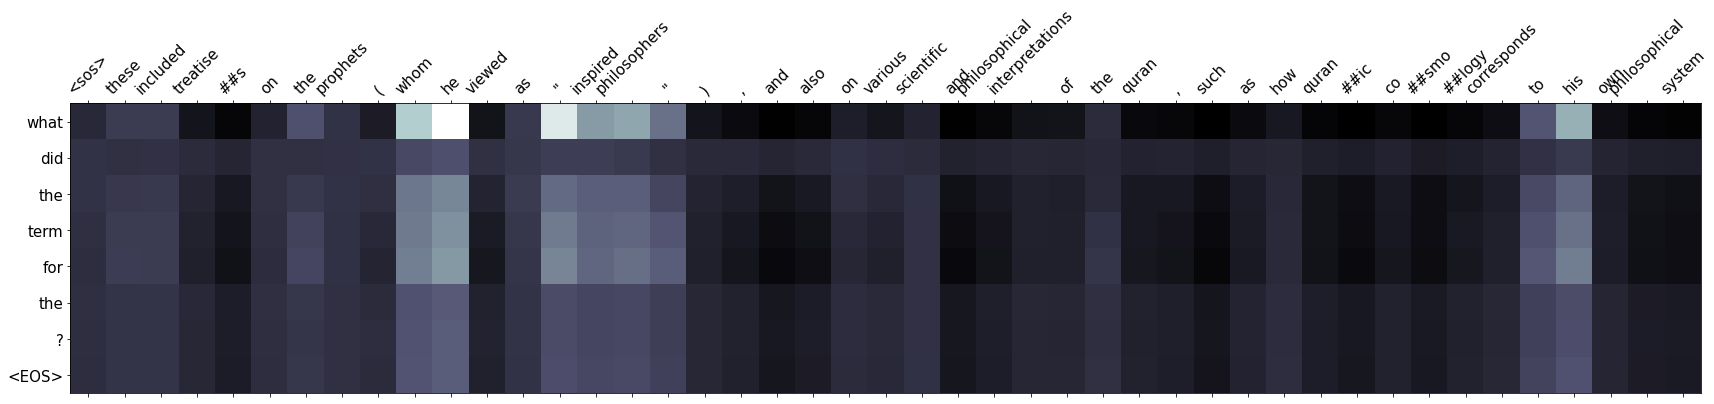

what did the term for the ? <EOS>


In [0]:
sent=random.choice(input_test)
pred,attn=model.decode(sent,inpLang,optLang)
display_attention(inpLang.tokenize(sent),pred.split(" "),attn)
print(pred)

# Convolution Seq2seq 

In [0]:
INPUT_DIM = INPUT_VOCAB
OUTPUT_DIM = OUTPUT_VOCAB
EMB_DIM = 300
HID_DIM = 600 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = optLang.word2idx[optLang.special["pad_token"]]
HYPERDASH=True
EPOCHS=6
CLIP=0.1

In [0]:
class Encoder(nn.Module):
    def __init__(self,inp_dim,emb_dim,hid_dim,n_layers,kernel_size,dropout,max_len,device):
        super(Encoder,self).__init__()
        assert kernel_size % 2 == 1
        self.device=device
        self.hid_dim=hid_dim
        self.kernel_size=kernel_size
        self.scale=torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.tok_embedding=nn.Embedding(inp_dim,emb_dim)
        self.pos_embedding=nn.Embedding(max_len,emb_dim)
        
        self.emb2hid=nn.Linear(emb_dim,hid_dim)
        self.hid2emb=nn.Linear(hid_dim,emb_dim)

        self.conv_blocks=nn.ModuleList([nn.Conv1d(in_channels=hid_dim,
                                    out_channels=2*hid_dim,
                                    kernel_size=kernel_size,
                                    padding=(kernel_size - 1) // 2)
                            for i in range(n_layers)])
        self.dropout=nn.Dropout(dropout)

    def forward(self,src):
        batch_size=src.shape[0]
        src_len=src.shape[1]
        pos=torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) # (batch , seq_len)
        tok_embedded=self.tok_embedding(src) #(batch, seq_len, emb_dim)
        pos_embedded=self.pos_embedding(pos) #(batch, seq_len, emb_dim)
        embedded=self.dropout(tok_embedded+pos_embedded)
        hidden=self.emb2hid(embedded) #(batch, seq_len, hid_dim)
        conv_input = hidden.permute(0, 2, 1) #(batch, hid_dim, seq_len)
        for i,conv in enumerate(self.conv_blocks):
            conved=conv(self.dropout(conv_input)) #(batch, 2 * hid_dim, src_len)
            conved = F.glu(conved,dim=1) #(batch, hid_dim, src_len)
            conved = (conved + conv_input) * self.scale #(batch, hid_dim, src_len)
            conv_input = conved
        conved=conved.permute(0, 2, 1) #(batch_size, src_len, hid_dim) 
        conved = self.hid2emb(conved) #(batch_size, src_len, emb_dim) 
        combined = (conved + embedded) * self.scale
        return conved, combined

In [0]:
class Decoder(nn.Module):
    def __init__(self,output_dim,emb_dim,hid_dim,n_layers,kernel_size,dropout,max_len,trg_pad_idx):
        super(Decoder,self).__init__()
        self.device=device
        self.output_dim=output_dim
        self.hid_dim=hid_dim
        self.kernel_size=kernel_size
        self.trg_pad_idx=trg_pad_idx
        self.scale=torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.tok_embedding=nn.Embedding(output_dim,emb_dim)
        self.pos_embedding=nn.Embedding(max_len,emb_dim)

        self.hid2emb=nn.Linear(hid_dim,emb_dim)
        self.emb2hid=nn.Linear(emb_dim,hid_dim)

        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)

        self.fc = nn.Linear(emb_dim, output_dim)

        self.conv_blocks=nn.ModuleList([nn.Conv1d(in_channels=hid_dim,
                                    out_channels=2*hid_dim,
                                    kernel_size=kernel_size)
                            for i in range(n_layers)])
        self.dropout=nn.Dropout(dropout)
    
    def calc_attn(self,embedded, conved, encoder_conved, encoder_combined):
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        combined = (conved_emb + embedded) * self.scale
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        attention = F.softmax(energy, dim=2)
        attended_encoding = torch.matmul(attention, encoder_combined)
        attended_encoding = self.attn_emb2hid(attended_encoding)
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        return attention, attended_combined

    def forward(self,trg,enc_conved,enc_combined):
        batch_size=trg.shape[0]
        trg_len=trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) #(batch, trg_len)

        tok_embedded = self.tok_embedding(trg) #(batch, trg_len, emb_dim)
        pos_embedded = self.pos_embedding(pos) #(batch, trg_len, emb_dim)
        embedded=self.dropout(tok_embedded+ pos_embedded) #(batch, trg_len, emb_dim)
        conv_input = self.emb2hid(embedded) #(batch, trg_len, hid_dim)
        conv_input = conv_input.permute(0, 2, 1) #(batch, hid_dim, trg_len)
        for i,conv in enumerate(self.conv_blocks):
            conv_input = self.dropout(conv_input)
            padding = torch.zeros(batch_size, 
                                  self.hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
            padded_conv_input = torch.cat((padding, conv_input), dim = 2) # (batch, hid_dim, trg_len + kernel_size -1)
            conved = conv(padded_conv_input) #(batch, 2*hid_dim , trg_len)
            conved = F.glu(conved, dim = 1) #(batch, hid_dim, trg_len)
            attention, conved = self.calc_attn(embedded, 
                                                conved, 
                                                enc_conved, 
                                                enc_combined) #(batch, trg_len, src_len),  (batch, hid_dim, trg_len)
            conved = (conved + conv_input) * self.scale
            conv_input = conved
        conved=conved.permute(0, 2, 1) #(batch, trg_len, hid_dim)
        conved = self.hid2emb(conved) #(batch, trg_len, emb_dim)
        output = self.fc(self.dropout(conved)) #(batch, trg_len, ouput_dim)
        return output, attention

In [0]:
class ConvSeq2seq(nn.Module):
    def __init__(self, inp_dim, opt_dim, emb_dim, hid_dim, enc_layers, 
                 dec_layers, enc_kernel_size, dec_kernel_size, enc_dropout, 
                 dec_dropout, max_len, device, trg_pad_idx):
        super(ConvSeq2seq,self).__init__()
        self.max_len=max_len
        self.device=device
        self.encoder=Encoder(inp_dim,emb_dim,hid_dim,enc_layers,enc_kernel_size,enc_dropout,max_len,device)
        self.decoder=Decoder(opt_dim,emb_dim,hid_dim,dec_layers,dec_kernel_size,dec_dropout, max_len,trg_pad_idx)
    def forward(self,src,trg):
        #src = [ src len, batch size]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
        encoder_conved, encoder_combined = self.encoder(src)
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        return output, attention
    def decode(self,input,inpLang,optLang):   
        stop_token=optLang.word2idx[optLang.special["eos_token"]]
        start_token=optLang.word2idx[optLang.special["init_token"]]
        src=torch.tensor(inpLang.encode(input),device=self.device).unsqueeze(1).transpose(0,1)
        batch_size=src.shape[0]
        trg_vocab_size=self.decoder.output_dim
        enc_out,hidden = self.encoder(src)
        outputs=[start_token]
        enc_conved, enc_combined=self.encoder(src)
        for i in range(self.max_len):
            input=torch.tensor(outputs,device=self.device).unsqueeze(0)
            output, attention = self.decoder(input, enc_conved, enc_combined)
            pred_token = output.argmax(2)[:,-1].item()
            outputs.append(pred_token)
            if pred_token == stop_token:
                break
        outputs=" ".join(optLang.decode(outputs))
        return outputs, attention


In [0]:
model=ConvSeq2seq(INPUT_DIM, OUTPUT_DIM, EMB_DIM,HID_DIM,
                  ENC_LAYERS, DEC_LAYERS, ENC_KERNEL_SIZE,
                  DEC_KERNEL_SIZE, ENC_DROPOUT, DEC_DROPOUT,
                  MAX_LEN, device, TRG_PAD_IDX).to(device)


In [0]:
it=iter(test_dataloader)
x,y,_=next(it)
print(y[:,:-1])
# model(x.to(device),y.to(device))

tensor([[   1,  192,    7,  ...,    0,    0,    0],
        [   1,    7,   26,  ...,    0,    0,    0],
        [   1,   17,  172,  ...,    0,    0,    0],
        ...,
        [   1,    8,    9,  ...,    0,    0,    0],
        [   1,   12,   20,  ...,    0,    0,    0],
        [   1,   25, 1280,  ...,    0,    0,    0]])


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 53,376,700 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model,iterator,optimizer,criterion,clip,exp):
    model.train()
    epoch_loss=0
    print("Total Batches - ",len(iterator))
    for i,(x,y,x_l) in enumerate(iterator):
        src=x.to(device)
        trg=y.to(device)
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        trg=trg[:,1:]
        trg=trg.transpose(0,1)
        output_dim=output.shape[-1]
        output=output.contiguous().view(-1,output_dim)
        trg=trg.contiguous().view(-1)
        loss=criterion(output,trg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),clip)
        optimizer.step()
        epoch_loss+=loss.item()
        if exp!=None:
            exp.metric("batch",i)
            exp.metric("loss",loss.item())
    return epoch_loss/len(iterator)

In [0]:
def eval(model,iterator,criterion,exp):
    model.eval()
    epoch_loss=0
    print("Total Batches - ",len(iterator))
    with torch.no_grad():
        for i,(x,y,x_l) in enumerate(iterator):
            src=x.to(device)
            trg=y.to(device)
            optimizer.zero_grad()
            output, _ = model(src, trg[:,:-1])
            trg=trg[:,1:]
            trg=trg.transpose(0,1)
            output_dim=output.shape[-1]
            output=output.contiguous().view(-1,output_dim)
            trg=trg.contiguous().view(-1)
            loss=criterion(output,trg)
            epoch_loss+=loss.item()
            if exp!=None:
                exp.metric("val_batch",i)
                exp.metric("val_loss",loss.item())
    return epoch_loss/len(iterator)

In [0]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
try:
    nmt_path="_translation" if testNMT else "" 
    if not os.path.exists(f"/content/drive/My Drive/ALDA Project/ConvSeq2seq{nmt_path}/"):
        os.mkdir(f"/content/drive/My Drive/ALDA Project/ConvSeq2seq{nmt_path}/")
    current_run= os.walk(f"/content/drive/My Drive/ALDA Project/ConvSeq2seq{nmt_path}/")
    folders=[int(i) for i in list(current_run)[0][1] if i.isdigit()]
    cur_run=max(folders)+1 if folders!=[] else 0
    model_path=f"/content/drive/My Drive/ALDA Project/ConvSeq2seq{nmt_path}/{str(cur_run)}/"
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    import math
    import pandas
    import pickle
    if HYPERDASH==True:
        from hyperdash import Experiment
        exp = Experiment("Question Generation-ConvSeq2seq")
        log_hyperdash(exp,**get_params())
    else:
        exp=None
    CLIP=0.1
    best_valid_loss=float('inf')

    for epoch in range(EPOCHS):
        if HYPERDASH:
            exp.metric("epoch",epoch)
        st_time=time.time()
        train_loss=train(model,train_dataloader,optimizer,criterion,CLIP,exp)
        valid_loss=eval(model,test_dataloader,criterion,exp)
        e_time=time.time()
        epoch_mins, epoch_secs = epoch_time(st_time, e_time)
        if valid_loss<best_valid_loss:
            best_valid_loss=valid_loss
            torch.save(model.state_dict(),model_path+"model.pt")
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    with open(model_path+"inpLang.p",'wb') as f:
        pickle.dump(inpLang,f)
    with open(model_path+"optLang.p",'wb') as f:
        pickle.dump(optLang,f)
    log_param(model_path+"param.txt",**get_params())
except Exception as e:
    print(f"Training stopped {e}")
finally:
    if HYPERDASH:
        exp.end()

{ BATCH_SIZE: 128 }
{ DEVICE: GPU }
{ testNMT: True }
{ SAMPLE: False }
{ MAX_LEN: 100 }
{ INPUT_VOCAB: 10000 }
{ OUTPUT_VOCAB: 10000 }
{ USE_PRETRAINED: False }
{ INPUT_DIM: 10000 }
{ OUTPUT_DIM: 10000 }
{ ENC_EMB_DIM: None }
{ DEC_HID_DIM: None }
{ HID_DIM: 600 }
{ ENC_DROPOUT: 0.25 }
{ DEC_DROPOUT: 0.25 }
{ N_LAYERS: None }
{ LR: None }
{ EPOCHS: 6 }
{ HYPERDASH: True }
{ CLIP: 0.1 }
{ TOKENIZER: spacy }
| epoch:   0.000000 |
Total Batches -  783
| batch:   0.000000 |
| loss:   9.321305 |
| batch:   2.000000 |
| loss:   8.833768 |
| batch:   4.000000 |
| loss:   9.156312 |
| batch:   6.000000 |
| loss:  14.502038 |
| batch:   8.000000 |
| loss:   7.940638 |
| batch:  10.000000 |
| loss:   7.074958 |
| batch:  12.000000 |
| loss:   7.623182 |
| batch:  14.000000 |
| loss:   8.556947 |
| batch:  16.000000 |
| loss:   7.511410 |
| batch:  18.000000 |
| loss:   6.225251 |
| batch:  20.000000 |
| loss:   7.891673 |
| batch:  22.000000 |
| loss:   6.302212 |
| batch:  24.000000 |
| loss: 

In [0]:
x=random.choice(input_)
model.decode(x,inpLang,optLang)

('el amor de mary . mary . mary . el <UNK> de mary . mary . el <UNK> de mary . el <UNK> de mary . mary . mary . mary . el <UNK> . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary . mary .',
 tensor([[[0.0065, 0.3775, 0.0538,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0043, 0.1225, 0.0818,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0072, 0.0348, 0.0343,  ..., 0.0000, 0.0000, 0.0000]],
 
         ...,
 
         [[0.0228, 0.1370, 0.0208,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0560, 0.1364, 0.0297,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0227, 0.1355, 0.0205,  ..., 0.0000, 0.0000, 0.0000]]],
        device='cuda:0', grad_fn=<CopySlices>))

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(len(sentence)/1.5,len(translation)/1.5))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention[:len(translation),:len(sentence)+1], cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [0]:
sent=random.choice(input_test)
pred,attn=model.decode(sent,inpLang,optLang)
display_attention(inpLang.tokenize(sent),pred.split(" "),attn)
print(pred)